In [1]:
#Importing Libraries
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [3]:
# Hyper-parameters
batch_size = 100
learning_rate = 0.001
n_epochs = 30
num_workers = 0

In [4]:
# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# load the training and test datasets
train_data = datasets.MNIST(root='.././data/mnist', train=True,
                                   download=True, transform=transform)
test_data = datasets.MNIST(root='.././data/mnist', train=False,
                                  download=True, transform=transform)

In [5]:
# Create training and test dataloaders
# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)


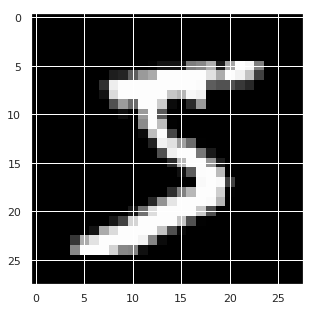

In [6]:
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
%matplotlib inline
    
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# get one image from the batch
img = np.squeeze(images[0])

fig = plt.figure(figsize = (5,5)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')

In [7]:
# define the NN architecture
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        ## encoder layers ##
        # conv layer (depth from 1 --> 16), 3x3 kernels
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)  
        # conv layer (depth from 16 --> 4), 3x3 kernels
        self.conv2 = nn.Conv2d(16, 4, 3, padding=1)
        # pooling layer to reduce x-y dims by two; kernel and stride of 2
        self.pool = nn.MaxPool2d(2, 2)
        
        ## decoder layers ##
        ## a kernel of 2 and a stride of 2 will increase the spatial dims by 2
        self.t_conv1 = nn.ConvTranspose2d(4, 16, 2, stride=2)
        self.t_conv2 = nn.ConvTranspose2d(16, 1, 2, stride=2)


    def forward(self, x):
        ## encode ##
        # add hidden layers with relu activation function
        # and maxpooling after
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        # add second hidden layer
        x = F.relu(self.conv2(x))
        x = self.pool(x)  # compressed representation
        
        ## decode ##
        # add transpose conv layers, with relu activation function
        x = F.relu(self.t_conv1(x))
        # output layer (with sigmoid for scaling from 0 to 1)
        x = F.sigmoid(self.t_conv2(x))
                
        return x

# initialize the NN
model = ConvAutoencoder().to(device)
print(model)

ConvAutoencoder(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (t_conv1): ConvTranspose2d(4, 16, kernel_size=(2, 2), stride=(2, 2))
  (t_conv2): ConvTranspose2d(16, 1, kernel_size=(2, 2), stride=(2, 2))
)


In [8]:
# Print model's number of trainable parameters

model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(params)

1077


In [9]:
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

Model's state_dict:
conv1.weight 	 torch.Size([16, 1, 3, 3])
conv1.bias 	 torch.Size([16])
conv2.weight 	 torch.Size([4, 16, 3, 3])
conv2.bias 	 torch.Size([4])
t_conv1.weight 	 torch.Size([4, 16, 2, 2])
t_conv1.bias 	 torch.Size([16])
t_conv2.weight 	 torch.Size([16, 1, 2, 2])
t_conv2.bias 	 torch.Size([1])


In [10]:
# specify loss function
criterion = nn.MSELoss()

# specify loss function
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [11]:
# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

Optimizer's state_dict:
state 	 {}
param_groups 	 [{'params': [140312892050168, 140312892050240, 140312892050672, 140312892050744, 140312892050816, 140312892050888, 140312892050960, 140312892051032], 'betas': (0.9, 0.999), 'amsgrad': False, 'weight_decay': 0, 'lr': 0.001, 'eps': 1e-08}]


In [12]:
# number of epochs to train the model
train_loss_history = []

for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = 0.0
    ###################
    # train the model #
    ###################
    for data in train_loader:
        # _ stands in for labels, here
        # no need to flatten images
        images, _ = data
        images = images.to(device)

        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        outputs = model(images)
        # calculate the loss
        loss = criterion(outputs, images)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*images.size(0)
        
        
    # print avg training statistics 
    train_loss = train_loss/len(train_loader)
    train_loss_history.append(train_loss)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch, 
        train_loss,
        ))

/home/mahfuj/pytorch_new_python3/lib/python3.5/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch: 1 	Training Loss: 6.981317
Epoch: 2 	Training Loss: 1.690445
Epoch: 3 	Training Loss: 1.535848
Epoch: 4 	Training Loss: 1.469806
Epoch: 5 	Training Loss: 1.419863
Epoch: 6 	Training Loss: 1.372763
Epoch: 7 	Training Loss: 1.333319
Epoch: 8 	Training Loss: 1.301725
Epoch: 9 	Training Loss: 1.274820
Epoch: 10 	Training Loss: 1.251833
Epoch: 11 	Training Loss: 1.231156
Epoch: 12 	Training Loss: 1.213019
Epoch: 13 	Training Loss: 1.196868
Epoch: 14 	Training Loss: 1.181660
Epoch: 15 	Training Loss: 1.166756
Epoch: 16 	Training Loss: 1.151759
Epoch: 17 	Training Loss: 1.135807
Epoch: 18 	Training Loss: 1.117864
Epoch: 19 	Training Loss: 1.099368
Epoch: 20 	Training Loss: 1.079927
Epoch: 21 	Training Loss: 1.060552
Epoch: 22 	Training Loss: 1.042872
Epoch: 23 	Training Loss: 1.028248
Epoch: 24 	Training Loss: 1.016447
Epoch: 25 	Training Loss: 1.006944
Epoch: 26 	Training Loss: 0.999131
Epoch: 27 	Training Loss: 0.992461
Epoch: 28 	Training Loss: 0.986722
Epoch: 29 	Training Loss: 0.9

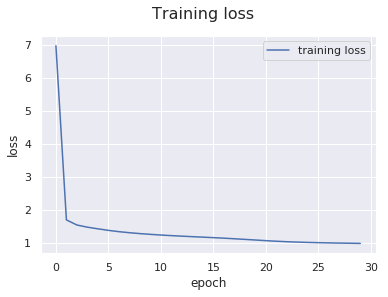

In [13]:
#plot the training and validation loss
plt.plot(train_loss_history, label='training loss')
plt.suptitle('Training loss', fontsize=16)
plt.xlabel('epoch', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.legend()

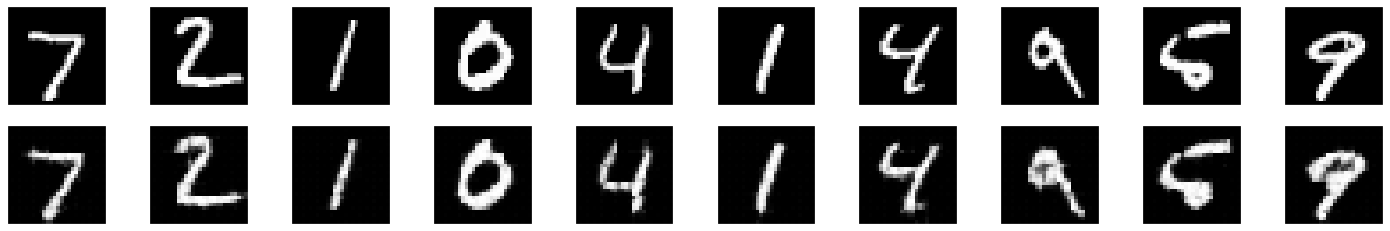

In [14]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

images = images.to(device)
labels = labels.to(device)

# get sample outputs
output = model(images)
# prep images for display
images = images.cpu().numpy()

# output is resized into a batch of iages
output = output.view(batch_size, 1, 28, 28)
# use detach when it's an output that requires_grad
output = output.detach().cpu().numpy()

# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

# input images on top row, reconstructions on bottom
for images, row in zip([images, output], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)